#  Affinity Propagation with MapReduce

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=2)

**Motivation** : Big data volume $\rightarrow$ need for *scalable* and *performance-concsious* analytics algorithms.\
MapReduce implementation of the exemplar-based clustering algorithm AP : 
 - parallelization stategy
 - extension to multilevel Hierachical AP
 - linear run-yime complexity ( << quadratic complexity with the original AP)
 - validation on synthetic and real datasets

## Introduction

**MapReduce** = one of the leading parallelization strategies. Robust open-source distribution Apache Hadoop. 
Introduced by Google, it is a programming paradigm designed to facilitate the distribution of computations on a cluster of computers. 
 1. **mapper phase** using key value identifiers for the distribution of data and subsequent independant execution to generate intermediate results
 2. **reducing phase** that gathers intermediate results to produce the final output key-value pairing.

**Clustering Techniques** = unsupervised solutions to aggregate similar data paterns. Key to discovering meaningful insightsand latent trends

*Rmk* : some clustering solution (K-means, Gaussian Mixture Models, ...) required the *number of cluster centers* which biasedly group the data.

**Affinity Propagation** (AP) : exemplar-based clustering approach : 
 - does not seek to find a mean for each cluster center but instead select representatibe data points as exemplar of clustered sub-groups. Does not require pre-set K cluster numbers
 - based on **"message passing""** framework where data points "talk" to each other in order to determine the most likely exemplar and autimatically determine the clusters.
 - based on **pairwise similarity measure** between all data points.
 
**Hierachical Affinity Propagation** (HAP) : extension of AP clustering which groups and stacks data in a tiered manner.
 - only required the nb of hierachy levels
 - limited usage though due to quadratic complexity. 
 
 $\rightarrow$ effective parallelization strategy for HAP using MapReduce
 


## Affinity Propagation Algorithm

 - Similarity : $s(i,k)$ shows how the data point $x_k$ is appropriate to be the center of data point $x_i$. 
 
 It is set to a negative squared error (euclidean distance) : $$s(i,k) = -||x_i - x_k||^2$$
 - $s(k,k)$ are called "preferances" : how likely a data point$x_k$ want to choose itself as the cluster center. This values are set to a common (changeable) value. In our case, it will be set as the median of the input similarities - which lead to a moderate nb of cluser (could be as well their minimum that would lead to a small number of cluster).
 
 Iteration : 
 
 - **availability** $a(i,k)$ : sent from point i to point k shows how appropriate for point i to choose point k as their cluster center. fot t=0, it is set to 0.
 - **responsibility** $r(i,k)$ : sent from point i to point k shows how well-suited point k is to be served as the cluster center for point i. The responsibility is computed by : 
 
 $$ r(i,k) \leftarrow s(i,k) - max_{k'|k'\ne k} \{a(i,k') + s(i,k')\} $$
 
 Then, the availability gathers evidence from data points to know if each candidate center would make a good cluster center : 
 
 $$ a(i,k) \leftarrow \min \{ 0, r(k,k) + \sum_{i'|i'\notin\{i,k\}} \max \{ 0,r(i',k)\}\}$$
 
 Although $r(k,k)$ is updated as all other pair of points, $a(k,k)$ is updated separatly :
 
 $$ a(k,k) \leftarrow \sum_{i'|i'\ne k} \max \{0,r(i',k)\}$$ 
 
 - **Damping step** : in order to avoid numerical oscillations when updating the messages, each message is "dampen" by :
 
 $$ updatedMessage \leftarrow updatedValue * (1 - \lambda) + oldValue * \lambda $$
 
 Usually, $\lambda$ is set to 0.5.
 
 - ** Temminal Condition** : 
     1. fixed nb of iterations
     2. changes of messages below a threshold value
     3. local decision stays constant for som nb of iterations.
     
- ** Attribution of cluster center ** : for each point, the point k that maximises $a(i,k) + r(i,k)$ identify the data center for point i - might be i itself if $k=i$.

- ** Iteration step ** : 
    1. updating all responsibilities given the availabilities
    2. updating availabilities given the responsibilities
    3. combining availibilities and responsibilities to monitor the center decisions and to decide termination or not.
  
  

### Scikit-Learnin implementation of Affinity Propagation

In [2]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import as_float_array, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin


from sklearn_affinity_propagation import AffinityPropagation

## Parallelization 

$\rightarrow$ MapReduce environment


#### Map Phase 

- divide the input data into samll pieces randomly and stored both source input data and the divided input data in HDFS.
    1. Initialize s(k,k) to zero : $s(k,k) = 0$
    2. Compute maximal preferance $P_{max} = \max \{s(i,k)\}$
    3. Compute the minimal preference :
$ dpsim1 = \max_j \{ \sum_j s(i,j) \} $ and 
$ dpsim2 = \max_{i \ne j} \{ \sum_k \max \{ s(i,k),s(j,k)\} \}$
    4. Compute the minimal preference : $P_{min} = dpsim1 - dpsim2 $


- Each mapper will preform AP on their own data. Each mapper has its own key. It will return data tuple $<key,i,k>$.

Remarques : each mapper should perform the AP independently on its own data. Why ?
1. in the AP, there are about hundreds of iterations needed. If all the information is exchanged at each iteration, a huge communication cost is expected in the MapReduce environment.
2. Every Mapper is isolated n processing which is restricted by the architecture to transfer data among mappers.

#### Reduce Phase 

2 parts : 
1. classify the points : Reducer A classifies the clustered points and sends the results to Reducer B to calculate the centers of clusters. If distance between two centers is less than a treshold, both clusters are combined into one. In practise, use $threshold = preference*0.5$. Points far away from centers are classified as *isolated points*. Points in the same clusers are sent to Reducer B with the same key.
2. calculate the center points : if there are multiple centers in a clusters : $centroids = \frac{c_1 + c2 + ... + c_K}{K}$.

cython, GIL, multi-process

In [3]:
import collections
import itertools
import numpy as np
import multiprocessing

## Implementation of Map-Reduce Affinity Propagation using Sklearn's style

In [5]:
from MRAP import MapReduceAffinityPropagation

### Small Test

Text(0,0.5,'y')

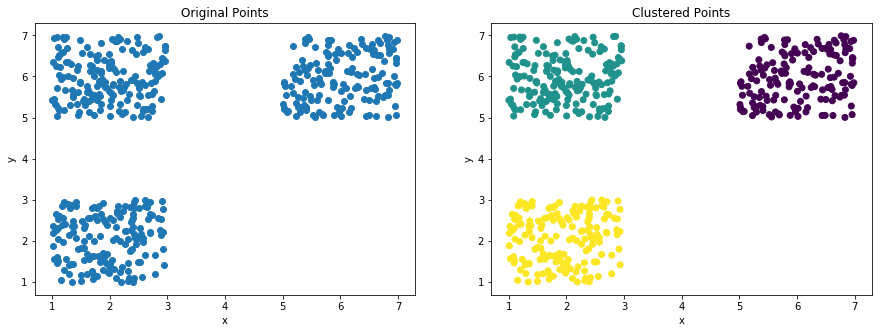

In [6]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


centers = [(1,1), (5,5), (1,5)]

def Generator(n, centers):
    while n>0 :
        center = centers[np.random.choice(len(centers))]
        yield center[0] + np.random.rand(1)[0]*2,  center[1] + np.random.rand(1)[0]*2
        n -= 1
        
points = [coord for coord in Generator(500, centers)]
MPAP = MapReduceAffinityPropagation(num_workers=2)
MPAP.fit(np.array(points), 2)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter([x for x,y in points], [y for x,y in points])
plt.title('Original Points')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter([x for x,y in points], [y for x,y in points], c = MPAP.predict(np.array(points)))
plt.title('Clustered Points')
plt.xlabel('x')
plt.ylabel('y')


## Stability and Run Time Comparison

0.77
-240
0.75
-220
0.9
-200
0.9
-200
0.9
-200
0.9
-200


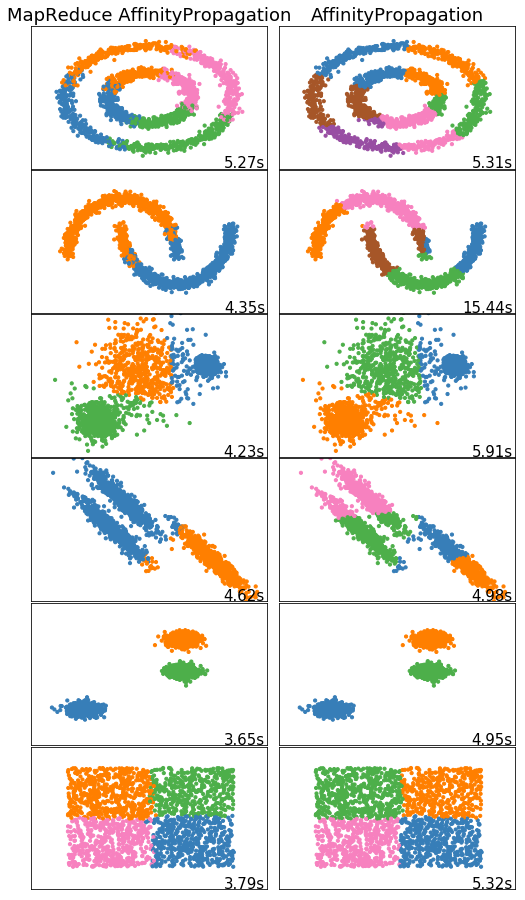

In [8]:
from Test import run_comparison
run_comparison(n_samples = 2000)

## Run Time Comparaison

In [7]:
#from sklearn.cluster import AffinityPropagation

import time
import gc
gc.collect()

run_time_dictionnary = {0 : [], 2 : [], 4 : [],6 : []}

algorithme = {0: AffinityPropagation(), 
              2 : MapReduceAffinityPropagation(num_workers=2),
              4 : MapReduceAffinityPropagation(num_workers=4),
              6 : MapReduceAffinityPropagation(num_workers=6)}

    
centers = [(1,1), (5,5), (1,5)]

def Generator(n, centers):
    while n>0 :
        center = centers[np.random.choice(len(centers))]
        yield center[0] + np.random.rand(1)[0]*2,  center[1] + np.random.rand(1)[0]*2
        n -= 1

init_point = [coord for coord in Generator(30, centers)]
for cores in [0,2,4,6] : 
    start = time.time()
    a = algorithme[cores]
    a.fit(init_point)
    end = time.time() - start
    print('Load Time with {} cores :'.format(cores), end )

for it in [50, 100, 500, 1000, 2000, 3000]:

    points = [coord for coord in Generator(it, centers)]
    print(len(points))
    
    for cores in [0,2,4,6]:
        start = time.time()
        ap = algorithme[cores]
        ap.fit(np.array(points))
        #ap.predict(points)
        end = time.time() - start

        l = run_time_dictionnary[cores]
        l.append(end)
    
    del points

#plt.scatter([x for x,y in points], [y for x,y in points], c = MRAP.predict(np.array(points)))

Load Time with 0 cores : 0.011968135833740234
Load Time with 2 cores : 1.5157356262207031
Load Time with 4 cores : 1.8441624641418457
Load Time with 6 cores : 2.123322010040283
50
100
500
1000
2000
3000


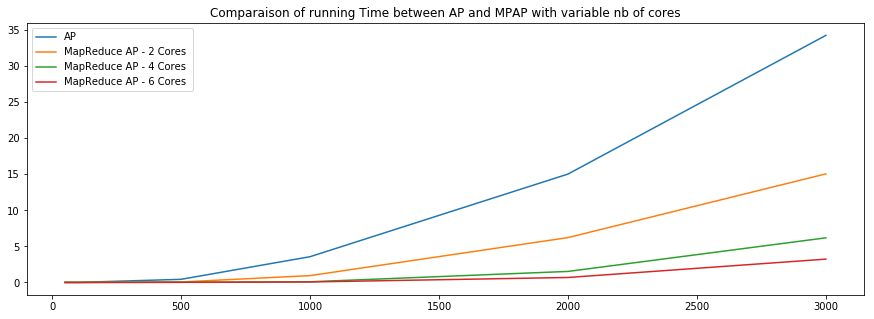

In [8]:
plt.figure(figsize = (15,5))

for cores in [0, 2 , 4, 6]:
    plt.plot([50, 100, 500, 1000, 2000, 3000], run_time_dictionnary[cores])

plt.legend(['AP', 'MapReduce AP - 2 Cores', 'MapReduce AP - 4 Cores ', 'MapReduce AP - 6 Cores' ])
plt.title('Comparaison of running Time between AP and MPAP with variable nb of cores')
plt.show()

In [5]:
import time

ap_time = []
mrap_time = []
mrap_time4 = []
mrap_time8 = []
for it in [50, 100, 500, 1000, 2000]:
    
    centers = [(1,1), (5,5), (1,5), (10,10),(15,15),(10,0), (15,5)]

    def Generator(n, centers):
        while n>0 :
            center = centers[np.random.choice(len(centers))]
            yield center[0] + np.random.rand(1)[0]*2,  center[1] + np.random.rand(1)[0]*2
            n -= 1

    points = [coord for coord in Generator(it, centers)]
    print(len(points))
    
    start = time.time()
    ap = AffinityPropagation()
    ap.fit(points)
    ap.predict(points)
    end = time.time() - start
    ap_time.append(end)
    
    start = time.time()
    MRAP = MapReduceAffinityPropagation(num_workers=2)
    MRAP.fit(np.array(points))
    end = time.time() - start
    mrap_time.append(end)
    
    start = time.time()
    MRAP = MapReduceAffinityPropagation(num_workers=4)
    MRAP.fit(np.array(points))
    end = time.time() - start
    mrap_time4.append(end)
    
    start = time.time()
    MRAP = MapReduceAffinityPropagation(num_workers=6)
    MRAP.fit(np.array(points))
    end = time.time() - start
    mrap_time8.append(end)

50
100
500
1000
2000


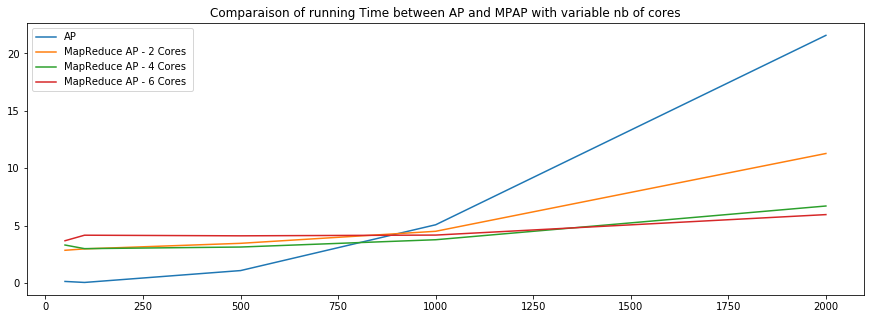

In [9]:
plt.figure(figsize = (15,5))

plt.plot([50, 100, 500, 1000, 2000], ap_time)
plt.plot([50, 100, 500, 1000, 2000], mrap_time)
plt.plot([50, 100, 500, 1000, 2000], mrap_time4)
plt.plot([50, 100, 500, 1000, 2000], mrap_time8)

plt.legend(['AP', 'MapReduce AP - 2 Cores', 'MapReduce AP - 4 Cores ', 'MapReduce AP - 6 Cores' ])
plt.title('Comparaison of running Time between AP and MPAP with variable nb of cores')
plt.show()